<a href="https://colab.research.google.com/github/Uppala19/Airline-fare-Prediction/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import holidays  # For marking holiday flights

import requests
import time


Load and Explore the Dataset

In [ ]:
# Load dataset
file_path = '/content/Data_Train.xlsx'  # Replace with your dataset path
data = pd.read_excel(file_path)

Size of data set

In [ ]:
data.shape

(10683, 11)

Inspect the dataset

In [ ]:
data.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


<ipython-input-125-fdeb1c90c279>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Price', y='Total_Stops', palette='Set2', showfliers=False)


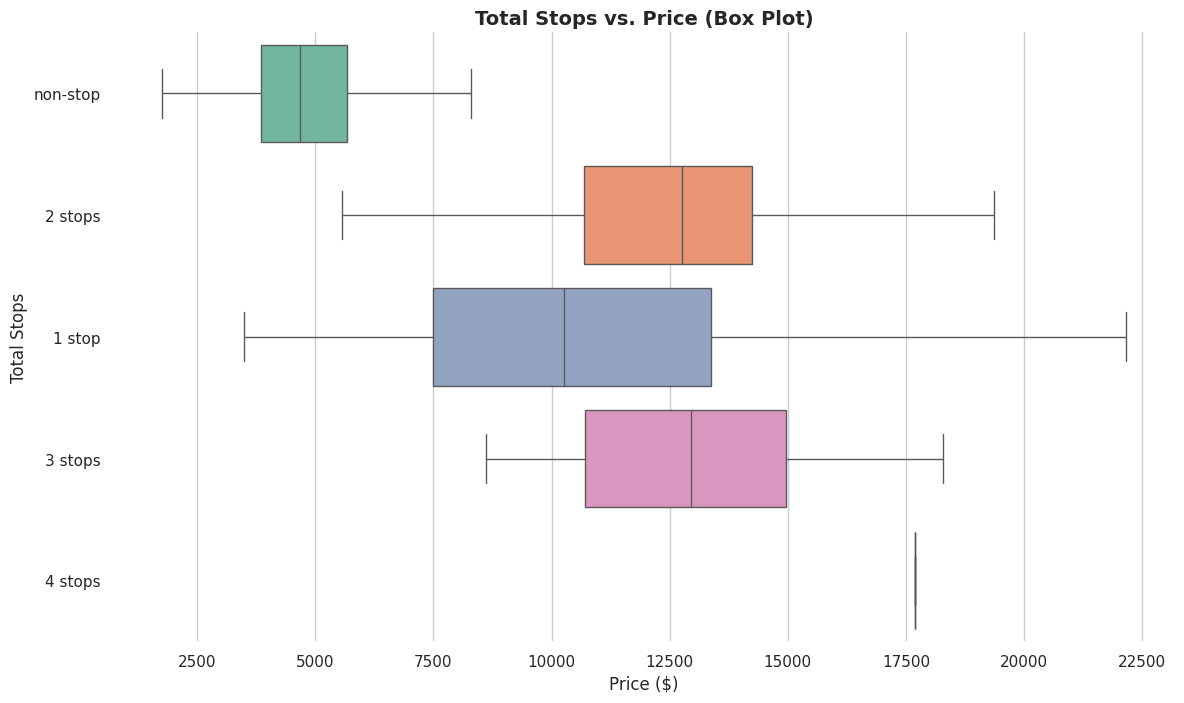

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size dynamically based on the number of unique stops
figsize = (12, 1.2 * len(data['Total_Stops'].unique()))
plt.figure(figsize=figsize)

# Create the box plot
sns.boxplot(data=data, x='Price', y='Total_Stops', palette='Set2', showfliers=False)

# Remove unnecessary spines for a clean look
sns.despine(top=True, right=True, bottom=True, left=True)

# Add title and labels
plt.title("Total Stops vs. Price (Box Plot)", fontsize=14, fontweight='bold')
plt.xlabel("Price ($)", fontsize=12)
plt.ylabel("Total Stops", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
data.iloc[-3:]  # Retrieves the last 5 rows


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648
10682,Air India,9/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,10:55,19:15,8h 20m,2 stops,No info,11753


#information about the data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [ ]:
data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


Check for missing values

In [ ]:
data.isnull().sum()

,0
Airline,0
Date_of_Journey,0
Source,0
Destination,0
Route,1
Dep_Time,0
Arrival_Time,0
Duration,0
Total_Stops,1
Additional_Info,0


Adding some neccesary data fields to already existing excel data set

In [ ]:
pip install pandas openpyxl geopy requests datetime holidays


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 9.7 MB/s eta 0:00:00


In [ ]:
data = pd.read_excel(file_path,engine='openpyxl')

Add Cabin Class

In [ ]:
cabin_classes = ['Economy', 'Business', 'First Class']
data['Cabin_Class'] = np.random.choice(cabin_classes, size=len(data))

Extract Layover Information from Route

In [ ]:
def get_layover(route):
    stops = route.count('→')  # Assuming route format like 'City1 → City2 → City3'
    return stops, "Direct" if stops == 0 else f"{stops} Stop(s)"

data[['Number_of_Stops', 'Flight_Layover']] = data['Route'].apply(lambda x: pd.Series(get_layover(str(x))))

Calculate Days Until Departure

In [ ]:
data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'], format='%d/%m/%Y')
#Generate random booking dates (For real case, replace with actual data)
data['Booking_Date'] = data['Date_of_Journey'] - pd.to_timedelta(np.random.randint(1, 60, size=len(data)), unit='D')
#Compute days until departure
data['Days_Until_Departure'] = (data['Date_of_Journey'] - data['Booking_Date']).dt.days


In [ ]:
  import requests
  import pandas as pd

  # Replace with your actual API key from Calendarific
  API_KEY = "NGcTjMSkwkZd1LT0ltkzOf9UdY0EzJ2k"

  # Define the API endpoint for fetching holidays in 2019
  url = f"https://calendarific.com/api/v2/holidays?api_key={API_KEY}&country=IN&year=2019"

  # Make the API request
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      holidays_data = response.json()

      # Extract holiday details
      holidays_list = holidays_data.get("response", {}).get("holidays", [])

      # Display the holiday details
      print(f"Airline Holidays for 2019 in India:\n")
      holiday_dates = []
      for holiday in holidays_list:
          holiday_date = holiday["date"]["iso"][:10] # Extract only the date part (YYYY-MM-DD)
          holiday_name = holiday["name"]
          holiday_type = holiday["type"]
          holiday_dates.append(holiday_date)
        # print(f"Date: {holiday_date} | Name: {holiday_name} | Type: {holiday_type}")

  else:
      print(f"Error: Unable to fetch holiday data (Status Code: {response.status_code})")

Airline Holidays for 2019 in India:



 Mark Holiday Season Flights

In [ ]:
    # Convert holiday dates to datetime format for comparison
    holiday_dates = pd.to_datetime(holiday_dates, format='%Y-%m-%d') # Specify the format

    # Mark flights as part of the holiday season (1 if holiday, 0 if not)
    data['Is_Holiday_Season'] = data['Date_of_Journey'].isin(holiday_dates).astype(int)
    #print(data)

Off-Peak Season Flag

In [ ]:
# Function to determine if the flight is in the peak season
def is_peak_season(row):
    # Define peak_months here
    peak_months = [12, 1, 2, 3, 4]  # Example: December to April are peak months

    # Check if the flight date is during a holiday or in peak months
    if row['Date_of_Journey'] in holiday_dates or row['Date_of_Journey'].month in peak_months:
        return 1  # Peak season
    return 0  # Non-peak season

# Apply the function to create the 'Is_Peak_Season' column
data['Is_Peak_Season'] = data.apply(is_peak_season, axis=1)
# Now, let's analyze fare prices during peak season vs non-peak season
peak_fares = data[data['Is_Peak_Season'] == 1]['Price']
non_peak_fares = data[data['Is_Peak_Season'] == 0]['Price']
# Calculate average fare for peak and non-peak season
average_peak_fare = peak_fares.mean()
average_non_peak_fare = non_peak_fares.mean()

#print(f"Average fare during peak season: {average_peak_fare}")
#print(f"Average fare during non-peak season: {average_non_peak_fare}")
#print(data)

adding Fuel price

In [ ]:
import requests
import pandas as pd

# Replace with your actual API key
API_KEY = "f695fbbb339ef3304ccefdd7091f56debe745901584075b65ef83213eba85aaf"

# Define the URL for the API request (this is just an example)
url = f"https://api.oilpriceapi.com/v1/prices?api_key={API_KEY}&start_date=2019-01-01&end_date=2019-12-31"
# Make the API request to get the latest fuel prices
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the response JSON
    fuel_data = response.json()

    # Extract the fuel prices from the response
    fuel_prices = pd.DataFrame(fuel_data['data'], columns=['date', 'price'])
    fuel_prices['date'] = pd.to_datetime(fuel_prices['date'])  # Convert to datetime



    # Merge the fuel prices with flight data based on the 'Date_of_Journey'
    data = data.merge(fuel_prices, left_on='Date_of_Journey', right_on='date', how='left')

    # Rename the 'price' column to 'Fuel_Price'
    data.rename(columns={'price': 'Fuel_Price'}, inplace=True)

    # Drop the 'date' column after merge
    data.drop(['date'], axis=1, inplace=True)

    # Display the merged data
    print(data)
else:
    print(f"Error: Unable to fetch fuel prices (Status Code: {response.status_code})")


Error: Unable to fetch fuel prices (Status Code: 401)


In [ ]:

data.to_excel("Updated_Flight_Fare_Data.xlsx", index=False, engine='openpyxl')

print("✅ Updated dataset saved successfully!")

✅ Updated dataset saved successfully!


Data Analysis And Visualization on train dataSet

In [ ]:
unique_airlines = pd.unique(data["Airline"])
print(unique_airlines)


['IndiGo' 'Air India' 'Jet Airways' 'SpiceJet' 'Multiple carriers' 'GoAir'
 'Vistara' 'Air Asia' 'Vistara Premium economy' 'Jet Airways Business'
 'Multiple carriers Premium economy' 'Trujet']


In [ ]:
for i in data:
    print(f"Number of unique values in {i} -->> {data[i].nunique()}")

Number of unique values in Airline -->> 12
Number of unique values in Date_of_Journey -->> 44
Number of unique values in Source -->> 5
Number of unique values in Destination -->> 6
Number of unique values in Route -->> 128
Number of unique values in Dep_Time -->> 222
Number of unique values in Arrival_Time -->> 1343
Number of unique values in Duration -->> 368
Number of unique values in Total_Stops -->> 5
Number of unique values in Additional_Info -->> 10
Number of unique values in Price -->> 1870


In [ ]:
for i in data:
    print(data[i].value_counts())

Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64
Date_of_Journey
18/05/2019    504
6/06/2019     503
21/05/2019    497
9/06/2019     495
12/06/2019    493
9/05/2019     484
21/03/2019    423
15/05/2019    405
27/05/2019    382
27/06/2019    355
24/06/2019    351
1/06/2019     342
3/06/2019     333
15/06/2019    328
24/03/2019    323
6/03/2019     308
27/03/2019    299
24/05/2019    286
6/05/2019     282
1/05/2019     277
12/05/2019    259
1/04/2019     257
3/03/2019     218
9/03/2019     200
15/03/2019    

<ipython-input-102-f029ea833f41>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Airline", data=data, palette="muted")


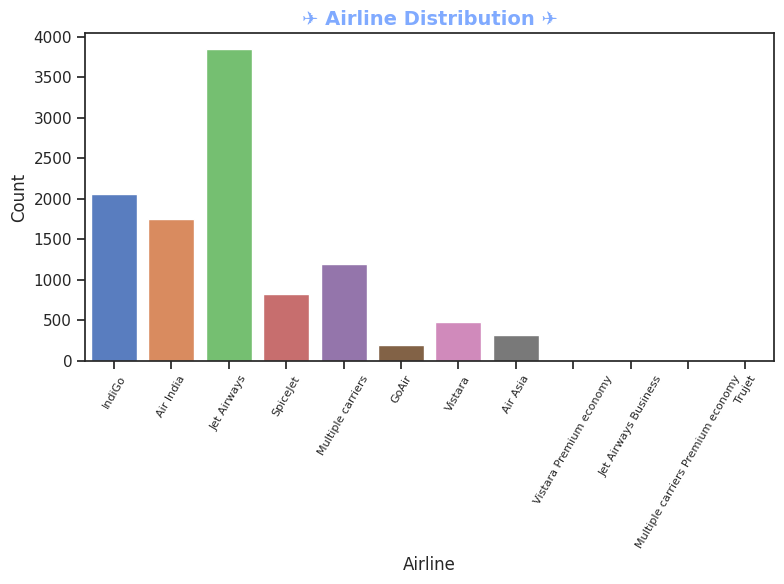

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a nice style
sns.set(style="ticks")

# Create the countplot with a color palette
plt.figure(figsize=(8, 6))
sns.countplot(x="Airline", data=data, palette="muted")


# Title and labels with styling
plt.title("✈️ Airline Distribution ✈️", fontweight="bold", fontsize=14, color="#80aaff")
plt.xlabel("Airline")
plt.ylabel("Count")

# Rotate x-tick labels for better readability
plt.xticks(rotation=60, fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()


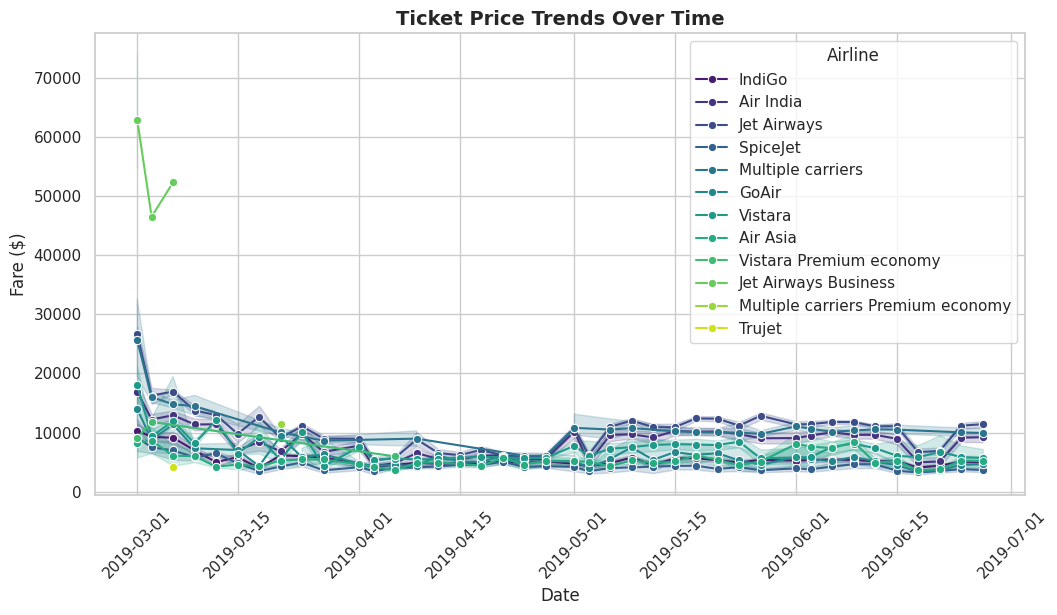

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x="Date_of_Journey", y="Price", data=data, hue="Airline", marker="o", palette="viridis") # Changed x to "Date_of_Journey" and y to "Price"

# Add title and labels
plt.title("Ticket Price Trends Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Fare ($)", fontsize=12)
plt.xticks(rotation=45)

# Show the plot
plt.show()


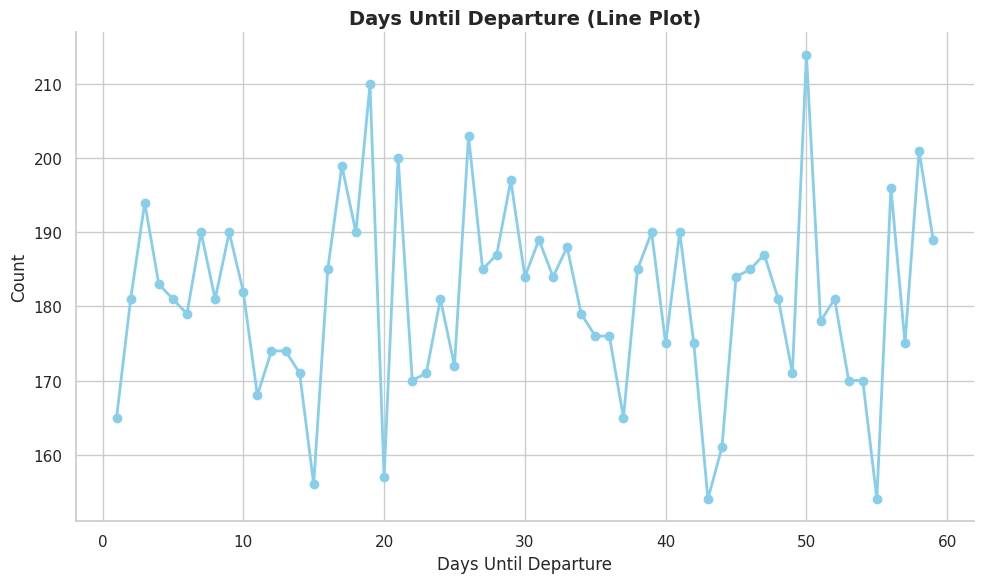

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'Days_Until_Departure' is in your data, we first calculate the frequency of each unique value
days_count = data['Days_Until_Departure'].value_counts().sort_index()

# Create a line plot for 'Days_Until_Departure'
plt.figure(figsize=(10, 6))
plt.plot(days_count.index, days_count.values, marker='o', color='skyblue', linewidth=2)

# Add title and labels
plt.title('Days Until Departure (Line Plot)', fontsize=14, fontweight='bold')
plt.xlabel('Days Until Departure', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Remove top and right spines for a clean look
plt.gca().spines[['top', 'right']].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()
